<a href="https://github.com/MiguelGV7799/TFM/tree/main">PHITSFusion</a> © 2026 by  
Miguel García, Manuel Cotelo  
is licensed under  
<a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">CC BY-NC-SA 4.0</a>

<img src="https://mirrors.creativecommons.org/presskit/icons/cc.svg" alt="CC" style="max-width: 1em;max-height:1em;">
<img src="https://mirrors.creativecommons.org/presskit/icons/by.svg" alt="BY" style="max-width: 1em;max-height:1em;">
<img src="https://mirrors.creativecommons.org/presskit/icons/nc.svg" alt="NC" style="max-width: 1em;max-height:1em;">
<img src="https://mirrors.creativecommons.org/presskit/icons/sa.svg" alt="SA" style="max-width: 1em;max-height:1em;">


In [87]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt

In [88]:
file_name = 'tcross_spectrum_photon.out'
df = pd.read_csv(
    file_name,
    delim_whitespace=True,
    skiprows=93,
    nrows=(394 - 94),
    names=["e_lower", "e_upper", "fn", "rerr"],  # 4ª columna suele ser r.err en t-cross
)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_11868\340836965.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [89]:
df

,e_lower,e_upper,fn,rerr
0,1.000000e-03,1.035000e-03,2.276200e-05,1.000000e+00
1,1.035000e-03,1.071100e-03,0.000000e+00,0.000000e+00
2,1.071100e-03,1.108600e-03,0.000000e+00,0.000000e+00
3,1.108600e-03,1.147300e-03,0.000000e+00,0.000000e+00
4,1.147300e-03,1.187500e-03,0.000000e+00,0.000000e+00
...,...,...,...,...
295,2.526400e+01,2.614700e+01,0.000000e+00,0.000000e+00
296,2.614700e+01,2.706100e+01,0.000000e+00,0.000000e+00
297,2.706100e+01,2.800700e+01,0.000000e+00,0.000000e+00
298,2.800700e+01,2.898700e+01,0.000000e+00,0.000000e+00


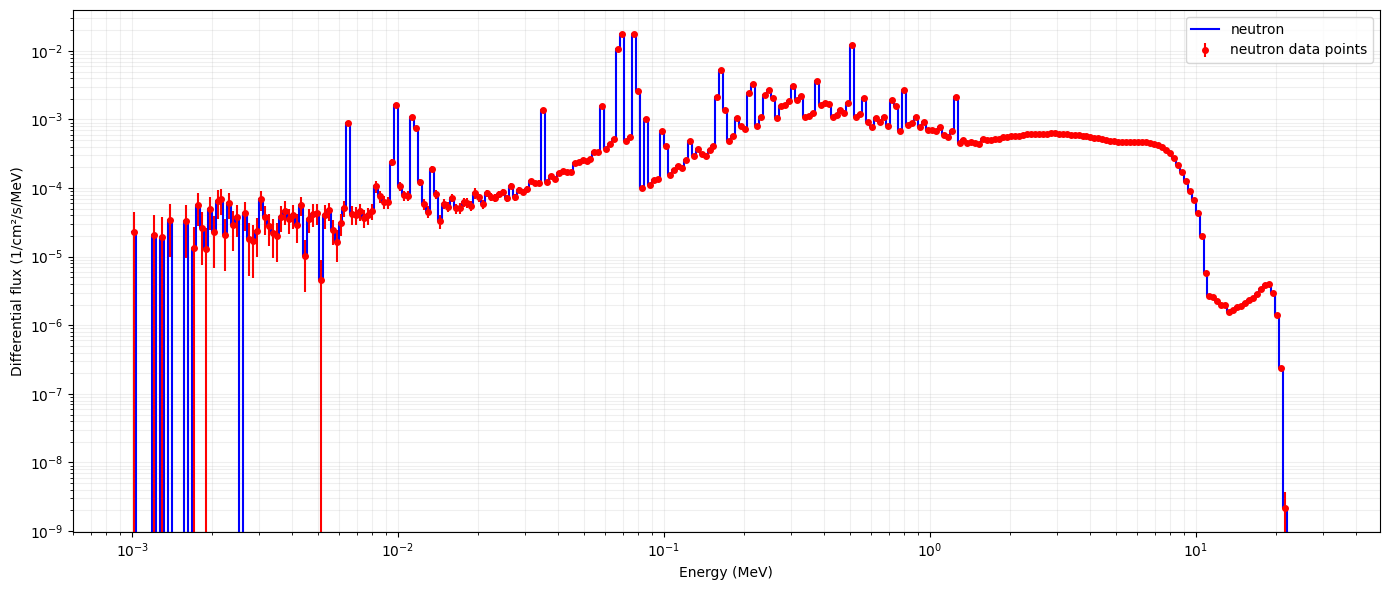

In [90]:
fig, ax = plt.subplots( 1, 1, figsize=(14,6) )

ax.set_xlabel( 'Energy (MeV)' )
ax.set_ylabel( 'Differential flux (1/cm²/s/MeV)' )

ax.set_xscale('log')
ax.set_yscale('log')

ax.step( df['e_lower'], df['fn'], where='post', label='neutron', color='blue' )
ax.errorbar(
    0.5 * (df['e_lower'] + df['e_upper']),
    df['fn'],
    yerr=df['fn']*df['rerr'],
    fmt='o',
    color='red',
    markersize=4,
    label='neutron data points'
)
ax.legend()
ax.grid(True, which='both', alpha=0.2)
plt.tight_layout()
plt.show()

\begin{align}

N & = A_{0} \cdot \int_{0}^{\infty} f(E) dE \\ 
& = A_{0} \sum^{bins} f_{i} \Delta_{i} \\
\\
E & = A_{0} \cdot \int_{0}^{\infty} E \cdot f(E) dE \\
& = A_{0} \cdot \sum^{bins} \int_{E_{i-1}}^{E_{i}} E f_{i} dE \\
& = A_{0} \cdot \sum^{bins} f_{i} \int_{E_{i-1}}^{E_{i}} E dE \\
& = A_{0} \cdot \sum^{bins} f_{i} \frac{1}{2} \left( E_{i}^{2} - E_{i-1}^{2} \right)
\end{align}

In [91]:
# integrate PDF

R = 1.
area_tally = 4.*np.pi*R*R
print( f"Radius used in the simulation: {R} cm (area = {4.*np.pi*R*R})" )

dE = df["e_upper"] - df["e_lower"]
E_mid = 0.5 * (df["e_upper"] + df["e_lower"])

N_total = area_tally * np.sum(df["fn"] * dE)
E_total = area_tally * np.sum(df["fn"] * E_mid * dE)

print(f"Total number of photons per source: {N_total:.6e} [1/source]")
print(f"Total photon energy crossing surface: {E_total:.6e} [MeV/source]")
if N_total > 0:
    print(f"Mean photon energy: {E_total/N_total:.6e} [MeV/photon]")


Radius used in the simulation: 1.0 cm (area = 12.566370614359172)
Total number of photons per source: 6.957047e-02 [1/source]
Total photon energy crossing surface: 2.446977e-01 [MeV/source]
Mean photon energy: 3.517263e+00 [MeV/photon]


In [92]:
import numpy as np
emin = 1e-3
k = 300
edel = np.log(14.1/emin)/k
print(edel)

0.03184643358788753


In [ ]:
bands = [
    (0.0,   1e-2,   "E < 10 keV"),
    (1e-2,  1e-1,   "10–100 keV"),
    (1e-1,  1.0,    "0.1–1 MeV"),
    (1.0,   10.0,   "1–10 MeV"),
    (10.0,  np.inf, "E > 10 MeV"),
]

def band_integrals(df, e_min, e_max, area):
    """
    Integra número de fotones y energía en una banda [e_min, e_max] (MeV),
    recortando bins parcialmente cuando es necesario.
    Devuelve (N_band, E_band).
    """
    eL = df["e_lower"].to_numpy()
    eU = df["e_upper"].to_numpy()
    fn = df["fn"].to_numpy()

    # Longitud de solapamiento de cada bin con la banda
    overlap = np.maximum(0.0, np.minimum(eU, e_max) - np.maximum(eL, e_min))

    # Número de fotones
    N_band = area * np.sum(fn * overlap)

    # Energía: usar energía media del tramo solapado
    a = np.maximum(eL, e_min)
    b = np.minimum(eU, e_max)
    E_avg = 0.5 * (a + b)

    E_band = area * np.sum(fn * E_avg * overlap)

    return N_band, E_band


rows = []
for e_min, e_max, label in bands:
    N_b, E_b = band_integrals(df, e_min, e_max, area_tally)
    rows.append({
        "Band": label,
        "E_min (MeV)": e_min,
        "E_max (MeV)": e_max if np.isfinite(e_max) else np.nan,
        "N_band [1/source]": N_b,
        "N_frac [%]": (100.0 * N_b / N_total) if N_total > 0 else np.nan,
        "E_band [MeV/source]": E_b,
        "E_frac [%]": (100.0 * E_b / E_total) if E_total > 0 else np.nan,
    })

df_bands = pd.DataFrame(rows)


pd.set_option("display.float_format", "{:.6e}".format)

print("\n=== Band-integrated results ===")
print(df_bands[
    ["Band",
     "N_band [1/source]",
     "N_frac [%]",
     "E_band [MeV/source]",
     "E_frac [%]"]
])





=== Band-integrated results ===
         Band  N_band [1/source]   N_frac [%]  E_band [MeV/source]  \
0  E < 10 keV       1.434792e-05 2.062358e-02         1.168221e-07   
1  10–100 keV       1.822052e-03 2.619001e+00         1.291149e-04   
2   0.1–1 MeV       1.726641e-02 2.481859e+01         8.955830e-03   
3    1–10 MeV       4.986485e-02 7.167532e+01         2.276274e-01   
4  E > 10 MeV       6.028064e-04 8.664688e-01         7.985238e-03   

    E_frac [%]  
0 4.774140e-05  
1 5.276508e-02  
2 3.659957e+00  
3 9.302392e+01  
4 3.263308e+00  
